In [56]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from os.path import join, basename
import pickle
from scipy.stats import pearsonr
import seaborn as sns

from filtering import freq_filt

In [2]:
banner_coords = (44.3, -115.233)
res = pd.read_csv('/bsuscratch/zacharykeskinen/data/infrasound/eq_catalog/selected_v2.csv')
from shapely import wkt
res['geometry'] = res['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(res, geometry = 'geometry', crs = 'EPSG:4326')

data_dir = '/bsuscratch/zacharykeskinen/data/infrasound/array_data'
with open(join(data_dir, 'merged/all_days'), 'rb') as f:
    days = pickle.load(f)
sps = 200

In [92]:
n = 0
for i, r in res[res.selected == 1].iterrows():
    dt = pd.to_datetime(r.time).strftime('%Y-%m-%d')
    day = days[dt]
    sig = {}
    s = pd.to_datetime(r.time)# + pd.Timedelta('4 second')
    e = s + pd.Timedelta('10 second')
    try:
        if 0.33 in day.keys() and 1.33 in day.keys():
            for name, fp in day.items():
                sig[name] = freq_filt(pd.read_parquet(fp)[s:e].values.ravel(), 1, kind = 'highpass')
            df = pd.DataFrame(sig)
            if i == 3:
                corr = df.corr()
            else: 
                corr = corr + df.corr()
            n += 1
    except ValueError:
        print(dt)

2022-03-20


In [91]:
corr

,0.33,0.66,1.00,1.33,2.00
0.33,93.000000,67.155743,54.110954,NaN,NaN
0.66,67.155743,93.000000,59.129267,NaN,NaN
1.00,54.110954,59.129267,93.000000,NaN,NaN
1.33,NaN,NaN,NaN,NaN,NaN
2.00,NaN,NaN,NaN,NaN,NaN


In [ ]:
corr = corr / n

<AxesSubplot:>

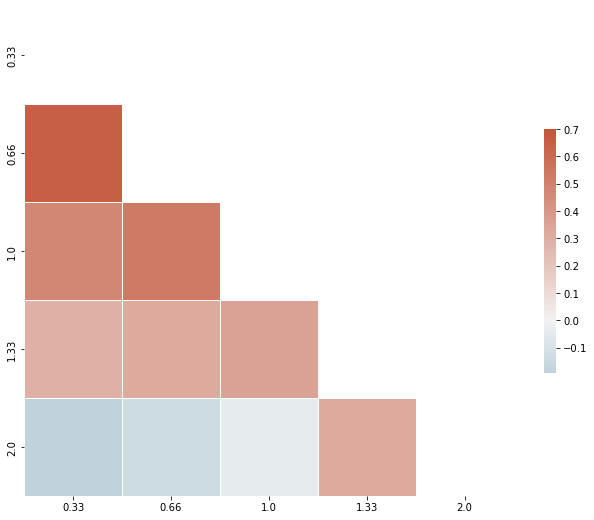

In [74]:
# corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:>

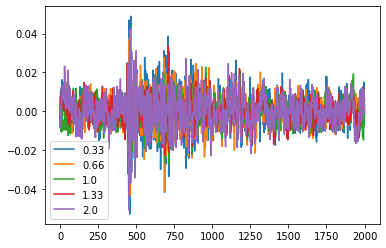

In [72]:
df.plot()